In [32]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score


In [33]:
import pickle

# Load the dataset from the pickle file
with open('processed/processed_final_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['features']  # Features
y = data['labels']    # Labels

In [34]:
X.shape

(2821051, 42)

In [ ]:
# Assuming 'y' is a numpy array containing class labels
previous_label = None
label_intervals = []

# Iterate over each label and identify intervals
for i, label in enumerate(y):
    if label != previous_label:
        if previous_label is not None:
            label_intervals.append((start_index, i - 1, previous_label))
        start_index = i
        previous_label = label

# Append the last interval
label_intervals.append((start_index, len(y) - 1, y[-1]))

# Print label intervals
for interval in label_intervals:
    start_idx, end_idx, label = interval
    print(f"Class {label}: Indices [{start_idx}, {end_idx}]")


In [36]:
def generate_sequences(data, labels, seq_length=10, seq_overlap=5):
    seqs = []
    seq_labels = []
    for i in range(0, len(data) - seq_length + 1, seq_length - seq_overlap):
        seq = data[i:i + seq_length]
        seq_label = labels[i:i + seq_length]
        # Use the most common label in the sequence as the sequence label
        most_common_label = np.bincount(seq_label).argmax()
        seqs.append(seq)
        seq_labels.append(most_common_label)
    return np.array(seqs), np.array(seq_labels)


# Generate sequences
sequences, seq_labels = generate_sequences(X, y)

In [37]:
seq_labels.shape

(564209,)

In [38]:
def select_balanced_test_set(sequences, seq_labels, samples_per_class=1000):
    unique_classes = np.unique(seq_labels)
    test_indices = []

    for cls in unique_classes:
        # Find indices where the sequence label is the class
        class_indices = np.where(seq_labels == cls)[0]
        # If there are fewer than required samples, take them all; otherwise, sample
        if len(class_indices) <= samples_per_class:
            test_indices.extend(class_indices)
        else:
            test_indices.extend(np.random.choice(class_indices, samples_per_class, replace=False))

    # Extract the sequences and labels for the test set
    test_seqs = sequences[test_indices]
    test_seq_labels = seq_labels[test_indices]
    return test_seqs, test_seq_labels

# Select balanced test set
test_X, test_y = select_balanced_test_set(sequences, seq_labels)


In [69]:
test_y.shape

(6150, 8)

In [39]:
def pad_sequences(seqs, seq_length):
    padded_seqs = []
    for seq in seqs:
        if len(seq) < seq_length:
            padded_seq = np.vstack((seq, np.zeros((seq_length - len(seq), seq.shape[1]))))
        else:
            padded_seq = seq
        padded_seqs.append(padded_seq)
    return np.array(padded_seqs)

In [40]:
# Pad sequences to ensure uniformity
test_X = pad_sequences(test_X, seq_length=10)

# Normalize the test data
# Assuming 'train_seqs' was your training dataset used to fit the normalization parameters
#mean = np.mean(train_seqs, axis=(0, 1))
#std = np.std(train_seqs, axis=(0, 1))
mean = np.array([-0.30251599, 0.43214656, -0.0071984, -0.040559, -0.13262795, -0.30594404,
                 1.01610603, -0.57040977, 0.34489319, 0.68380633, 0.01809874, -0.04045581,
                 0.00344279, 0.31909552, -0.16974303, 0., -0.01056754, 0., 
                 0.00124247, 0.00163327, 0.09341123, 0.06387345, -0.62513747, 0.39036366,
                 -0.01559586, 0.34854081, 0.26082964, -0.30246426, -0.09879487, 0., 
                 0., 0., 0., 0., 0., 0.01556358, -0.21182333, 0.00255652, -0.01398662,
                 -0.05906157, -0.06749402, 0.20718232])

std = np.array([4.47656907e-01, 1.25963045e+00, 4.10815829e-03, 3.17013314e-02,
                2.28254224e-01, 5.82985819e-02, 1.77483654e+00, 2.00166998e-01,
                1.22776363e+00, 1.53183995e+00, 1.29877994e+00, 9.30325112e-01,
                8.03830508e-01, 1.76526422e+00, 4.87879356e-01, 1e-7,  # Replaced 0 with a small value
                7.60988494e-14, 1e-7,  # Replaced 0 with a small value
                4.58429628e-06, 7.96110689e-05, 1.22611589e+00, 1.00794963e+00,
                6.92865015e-02, 1.67553342e+00, 9.10348186e-14, 1.09050881e+00,
                1.06688757e+00, 2.65669909e-01, 8.67575085e-01, 1e-7,  # Replaced 0 with a small value
                1e-7, 1e-7, 1e-7, 1e-7, 1e-7, 8.03441259e-01,
                1.72948384e-01, 6.72715809e-06, 7.71187226e-01, 7.92794469e-01,
                6.02577562e-01, 1.82455050e+00])


std[std == 0] = 1  # Avoid division by zero

normalized_test_X = (test_X - mean) / std

# Convert labels to categorical for the model
test_y = to_categorical(test_y , 8)  # Adjust label indices and set number of classes



In [46]:
print("test_X shape: " , test_X.shape)
print("\ntest_y shape: " , test_y.shape)


test_X shape:  (6150, 10, 42)

test_y shape:  (6150, 8)


In [ ]:
test_y[501]

In [48]:
from tensorflow.keras.models import load_model

# Load the saved best binary classifier model
model_binary = load_model('models/best_binary_model_42features.keras')
multiclass_model = load_model('models/best_multiclass.keras')


C:\Users\jinur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
def sample_predict_evaluate(test_X, test_y, model_binary, num_samples=100):
    # Ensure that test_y is in the expected shape: (n_samples, n_classes)
    print("Shape of test_y before sampling:", test_y.shape)
    
    # Randomly select sequences and their corresponding labels
    indices = np.random.choice(test_X.shape[0], num_samples, replace=False)
    sampled_sequences = test_X[indices]
    sampled_labels = test_y[indices]
    #print(sampled_labels)
    
    # List to hold predictions and actual labels for calculating accuracy
    predictions = []
    true_labels = []

    # Process each sequence
    for sequence, one_hot_labels in zip(sampled_sequences, sampled_labels):
        #print(sampled_labels)
        # Predict using the binary model for each point in the sequence
        pred_probs = model_binary.predict(sequence)  # shape should be (10, 1) if model expects (1, num_features)
        
        #print("predicted prb", pred_probs.shape)
        # Calculate the average prediction for the sequence
        avg_pred = np.mean(pred_probs)
        predicted_label = 1 if avg_pred > 0.50 else 0
        
        predictions.append(predicted_label)
        
        # Make sure we handle labels correctly
        if one_hot_labels.ndim == 1:
            true_label = np.argmax(one_hot_labels)
        else:
            true_label = np.argmax(np.bincount(np.argmax(one_hot_labels, axis=1)))
        
        if true_label > 0 :
            true_label = 1
        
        
        true_labels.append(true_label)
        
        # Print both the predicted and the true label
        print(f"Predicted average: {avg_pred:.4f}, Predicted label: {predicted_label}, True label: {true_label}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\nAccuracy of the model on the sampled data: {accuracy:.4%}")

    return predictions, true_labels, accuracy

# Example usage
predictions, true_labels, accuracy = sample_predict_evaluate(test_X, test_y, model_binary, num_samples=1000)


Shape of test_y before sampling: (6150, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted average: 0.0000, Predicted label: 0, True label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
Predicted average: 0.7842, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted average: 0.9993, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted average: 0.9928, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted average: 1.0000, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted average: 0.9991, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted average: 0.8985, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted average: 0.7841, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted average: 0.8789, Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted average: 0.9999, 

In [63]:

def sample_predict_evaluate(test_X, test_y, model_binary, model_multiclass, num_samples=100):
    # Ensure that test_y is in the expected shape: (n_samples, n_classes)
    print("Shape of test_y before sampling:", test_y.shape)
    
    # Randomly select sequences and their corresponding labels
    indices = np.random.choice(test_X.shape[0], num_samples, replace=False)
    sampled_sequences = test_X[indices]
    # Calculate the maximum sequence length
    max_sequence_length = max(len(seq) for seq in sampled_sequences)

    # Reshape to include batch dimension and variable sequence length
    sampled_sequences = np.array([np.pad(seq, ((0, max_sequence_length - len(seq)), (0, 0)), mode='constant') for seq in sampled_sequences])
    sampled_sequences = sampled_sequences.reshape(-1, max_sequence_length, 42)  # Assuming 42 is the number of features
    sampled_labels = test_y[indices]
    
    # List to hold predictions and actual labels for calculating accuracy
    predictions = []
    true_labels = []

    # Process each sequence
    for sequence, one_hot_labels in zip(sampled_sequences, sampled_labels):
        # Predict using the binary model for each point in the sequence
        pred_probs = model_binary.predict(sequence)
        avg_pred = np.mean(pred_probs)
        
        # If binary model predicts attack (avg_pred > 0.50)
        if avg_pred > 0.50:
            # Reshape sequence to match expected input shape of multiclass model
            sequence = np.expand_dims(sequence, axis=0)  # Add batch dimension
            multiclass_pred_probs = model_multiclass.predict(sequence)
            predicted_label = np.argmax(multiclass_pred_probs) + 1  # Assuming class labels start from 1
        else:
            predicted_label = 0  # Not an attack

        
        # Determine the true label (for evaluation purposes)
        if one_hot_labels.ndim == 1:
            true_label = np.argmax(one_hot_labels)
        else:
            true_label = np.argmax(np.bincount(np.argmax(one_hot_labels, axis=1)))
        
        # Append to lists
        predictions.append(predicted_label)
        true_labels.append(true_label)
        
        # Print both the predicted and the true label
        print(f"Predicted label: {predicted_label}, True label: {true_label}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\nAccuracy of the model on the sampled data: {accuracy:.4%}")

    return predictions, true_labels, accuracy


In [70]:
# Example usage
predictions, true_labels, accuracy = sample_predict_evaluate(test_X, test_y, model_binary, multiclass_model, num_samples=6150)

Shape of test_y before sampling: (6150, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted label: 5, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted label: 3, True label: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted label: 0, True label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted label: 3, True label: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted label: 0, True label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted label: 1, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted label: 6, True label: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted label: 5, True label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted label: 0, True label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predic

RESULTS

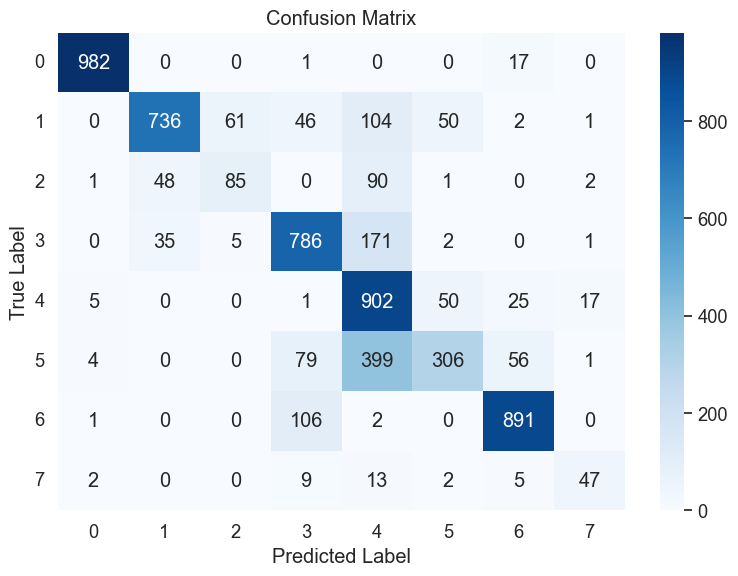

In [75]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels (modify based on your specific class labels)
classes = np.unique(true_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot as an image file (e.g., PNG)
plt.savefig('outputs/confusion_matrix.png')

# Show the plot (optional, depending on your environment)
plt.show()


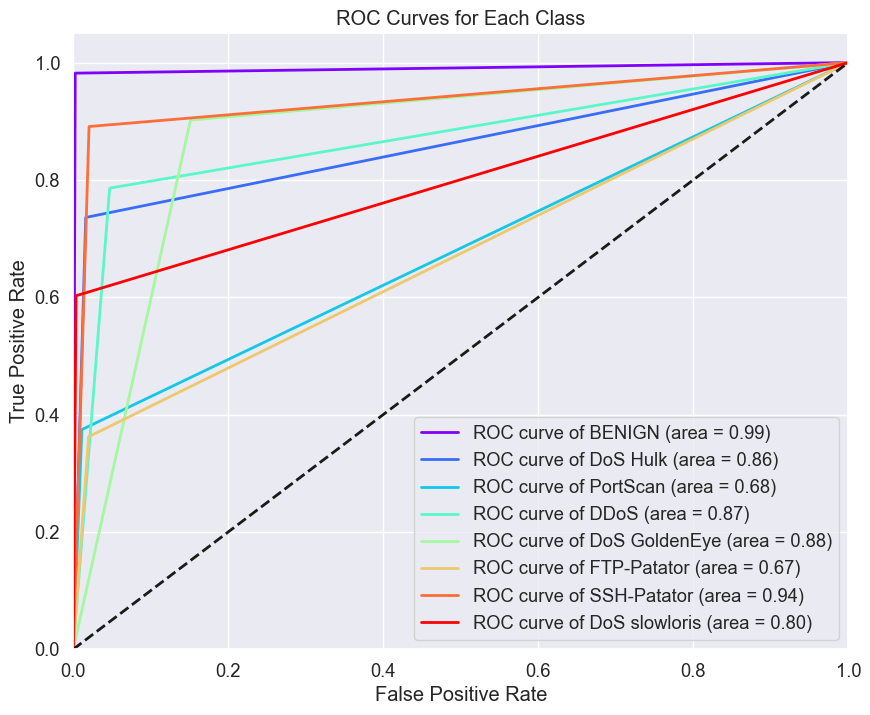

In [83]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert true_labels and predictions to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Define class names based on your encoding order
class_names = {
    0: 'BENIGN',
    1: 'DoS Hulk',
    2: 'PortScan',
    3: 'DDoS',
    4: 'DoS GoldenEye',
    5: 'FTP-Patator',
    6: 'SSH-Patator',
    7: 'DoS slowloris'
}

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Convert boolean arrays to integer arrays (0s and 1s) for the current class
    y_true = (true_labels == i).astype(int)
    y_pred = (predictions == i).astype(int)
    
    # Compute ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))  # Generate colors for classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")

# Save the plot as an image file (e.g., PNG)
plt.savefig('outputs/roc_curves_with_attack_names.png')

# Show the plot (optional, depending on your environment)
plt.show()


F1 Score: 0.7639377099685712


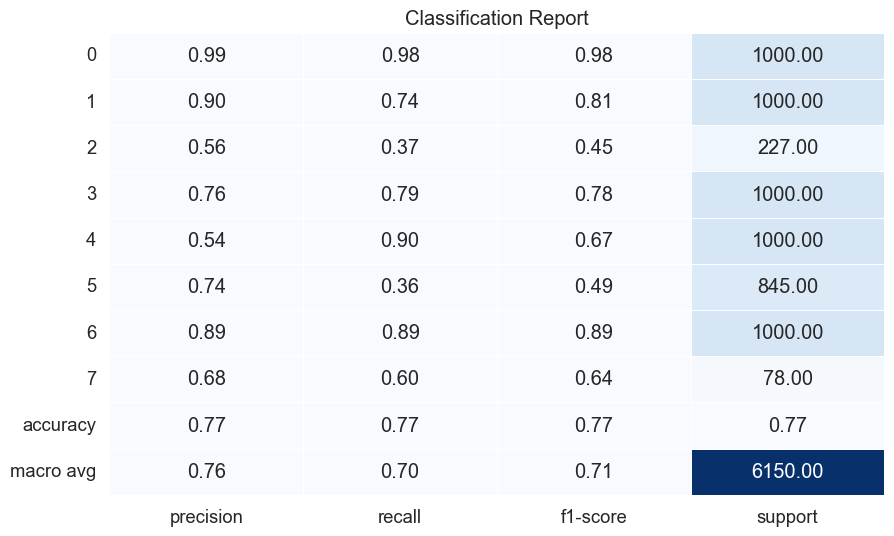

In [81]:
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Compute F1 score
f1 = f1_score(true_labels, predictions, average='weighted')
print("F1 Score:", f1)

# Generate classification report as a DataFrame
report_dict = classification_report(true_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Plot classification report as a heatmap
plt.figure(figsize=(10, 6))
plt.title('Classification Report')
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, cbar=False)
plt.yticks(rotation=0)
plt.savefig('outputs/classification_report.png')
plt.show()


In [85]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, accuracy_score

# Assuming you have true_labels and predictions as numpy arrays

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Extract TP, TN, FP, FN from confusion matrix (for binary classification, adjust as needed)
TP = np.diag(cm)  # True Positives (per class)
FP = np.sum(cm, axis=0) - TP  # False Positives (per class)
FN = np.sum(cm, axis=1) - TP  # False Negatives (per class)
TN = np.sum(cm) - (TP + FP + FN)  # True Negatives (per class)

# Compute precision, recall, FPR, and specificity for each class
precision = TP / (TP + FP)
recall = TP / (TP + FN)
FPR = FP / (FP + TN)
specificity = TN / (TN + FP)

# Overall metrics (weighted average)
weighted_precision = precision_score(true_labels, predictions, average='weighted')
weighted_recall = recall_score(true_labels, predictions, average='weighted')
weighted_FPR = np.sum(FP) / (np.sum(FP) + np.sum(TN))
weighted_specificity = np.sum(TN) / (np.sum(TN) + np.sum(FP))
accuracy = accuracy_score(true_labels, predictions)

# Print the computed metrics
print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("False Positive Rate (FPR) (per class):", FPR)
print("Specificity (True Negative Rate) (per class):", specificity)
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted False Positive Rate (FPR):", weighted_FPR)
print("Weighted Specificity (True Negative Rate):", weighted_specificity)
print("Accuracy:", accuracy)


Precision (per class): [0.98693467 0.8986569  0.56291391 0.76459144 0.53658537 0.74452555
 0.89457831 0.68115942]
Recall (per class): [0.982      0.736      0.37444934 0.786      0.902      0.36213018
 0.891      0.6025641 ]
False Positive Rate (FPR) (per class): [0.00252427 0.0161165  0.011143   0.04699029 0.15126214 0.01979265
 0.02038835 0.00362319]
Specificity (True Negative Rate) (per class): [0.99747573 0.9838835  0.988857   0.95300971 0.84873786 0.98020735
 0.97961165 0.99637681]
Weighted Precision: 0.7953467756335953
Weighted Recall: 0.7699186991869919
Weighted False Positive Rate (FPR): 0.03286875725900116
Weighted Specificity (True Negative Rate): 0.9671312427409988
Accuracy: 0.7699186991869919
